This notebook contains the first models that we produced. It includes the exhaustive search model and other attempts to find the best variables to include in our models.

In [45]:
import pandas as pd 
import numpy as np
# import geopandas as gpd 
from patsy import dmatrices
import statsmodels.api as sm
import os

# Initial Modeling

This is the jupyter notebook that we turned in for the modeling markdown assignment.

## Data Cleaning and Editing
We first include a data cleaning section before we start our modeling portion of the lab.

You can find `geogon_od.csv` in `Data\od_deaths_Versions\geogon_od.csv`

In [5]:
# Navigating to csv file
geogon_od = pd.read_csv('geogon_od.csv')

In [7]:
geogon_od 

# Rename our columns to have no spaces (needed for OLS modeling later)
geogon_od.columns = ['Year', 'FIPS', 'State', 'County', 'Deaths', 'Population', 'Crude_Rate',
       'Cruder_Rate', 'Deathrate_per_100', 'Unemployment_rate',
       'Dispense_rate', 'SUMLEV', 'AGEGRP', 'TOT_POP', 'TOT_MALE',
       'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE',
       'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE',
       'TOM_FEMALE', 'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE',
       'Urbanicity', 'Jail_Population', 'Incarceration_Rate_per_100k',
       'PovertyCount', 'PovertyPercentage', 'MedianHHI', 'Latitude',
       'Longitude', 'geometry']


# Convert FIPS to string 
geogon_od['FIPS'] = geogon_od['FIPS'].astype(str).str.zfill(5) 
geogon_od

,Year,FIPS,State,County,Deaths,Population,Crude_Rate,Cruder_Rate,Deathrate_per_100,Unemployment_rate,...,H_FEMALE,Urbanicity,Jail_Population,Incarceration_Rate_per_100k,PovertyCount,PovertyPercentage,MedianHHI,Latitude,Longitude,geometry
0,1999.0,01003,Alabama,"Baldwin County, AL",11.0,137555.0,Unreliable,7.996801,0.007997,NaN,...,NaN,small/mid,390.000000,440.340000,14668.0,10.5,39194.0,30.659218,-87.746067,"POLYGON ((-88.026319 30.753358, -87.944546 30...."
1,1999.0,01073,Alabama,"Jefferson County, AL",34.0,662845.0,5.13,5.129404,0.005129,NaN,...,NaN,urban,1779.000000,408.230000,89661.0,13.7,35885.0,33.553444,-86.896536,"POLYGON ((-87.26692299999999 33.512929, -87.27..."
2,1999.0,01089,Alabama,"Madison County, AL",10.0,274693.0,Unreliable,3.640428,0.003640,NaN,...,NaN,small/mid,713.000000,382.130000,30056.0,11.1,43718.0,34.764238,-86.551080,"POLYGON ((-86.78362801716901 34.991924921992, ..."
3,1999.0,01097,Alabama,"Mobile County, AL",28.0,399323.0,7.01,7.011868,0.007012,NaN,...,NaN,small/mid,1223.000000,470.210000,72372.0,18.3,32396.0,30.684572,-88.196568,"POLYGON ((-88.432007 31.114297999999998, -88.3..."
4,1999.0,02020,Alaska,"Anchorage Borough, AK",21.0,259348.0,8.10,8.097228,0.008097,NaN,...,NaN,small/mid,NaN,NaN,18397.0,7.2,52959.0,61.174250,-149.284329,"POLYGON ((-150.228774 61.162580999999996, -150..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15891,2020.0,55139,Wisconsin,"Winnebago County, WI",38.0,171631.0,22.14,22.140522,0.022141,5.4,...,NaN,NaN,NaN,NaN,14219.0,8.7,64653.0,44.085707,-88.668149,"POLYGON ((-88.886673 44.242622, -88.7662 44.24..."
15892,2020.0,55141,Wisconsin,"Wood County, WI",18.0,72560.0,Unreliable,24.807056,0.024807,6.7,...,NaN,NaN,NaN,NaN,6732.0,9.4,54154.0,44.461413,-90.038825,"POLYGON ((-90.31605499999999 44.424502, -90.31..."
15893,2020.0,56021,Wyoming,"Laramie County, WY",17.0,100595.0,Unreliable,16.899448,0.016899,5.1,...,NaN,NaN,NaN,NaN,7242.0,7.4,69450.0,41.292830,-104.660395,"POLYGON ((-105.27823599999999 41.656655, -104...."
15894,2020.0,56025,Wyoming,"Natrona County, WY",16.0,80815.0,Unreliable,19.798305,0.019798,7.8,...,NaN,NaN,NaN,NaN,7420.0,9.4,65901.0,42.977645,-106.768219,"POLYGON ((-107.543526 42.781558, -107.501425 4..."


### Dealing with missing data

In [9]:
import missingno as msno

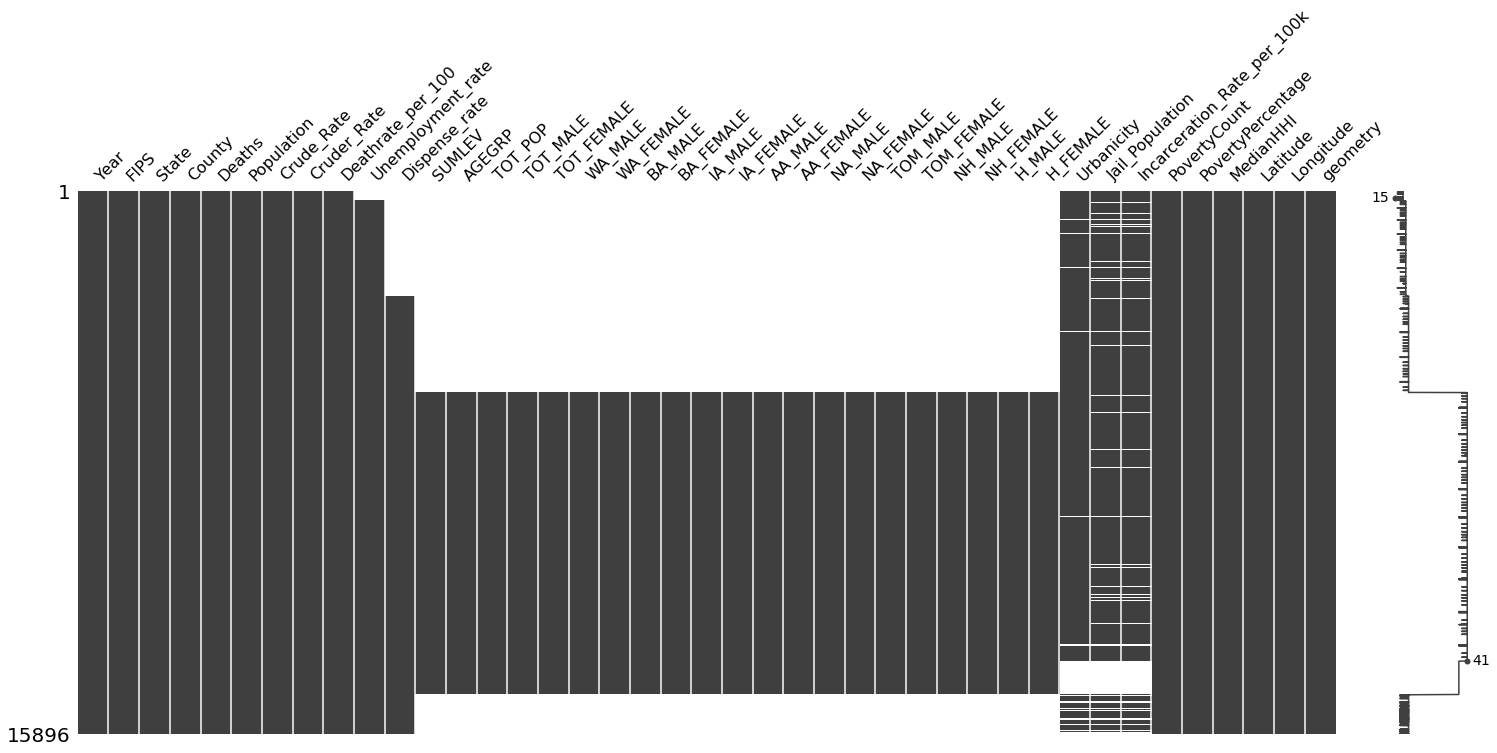

In [10]:
msno.matrix(geogon_od);

we will only be considering 2010-2019 since we are missing the demographics data from all other years. 


we will be adding in the 2018 Incarceration_Rate_per_100k as a replacement for it's 2019 data (note there was a big decrease in incarceration rates in 2020 bc of the quarantine so we did not take an avg of the two adjacent years) 

In [11]:
### Analyze our data without most of the demographic data 
geogon_nodem = geogon_od.drop(geogon_od.columns[15:32], axis = 1)
# geogon_od.drop(nonnum_features, axis = 1)

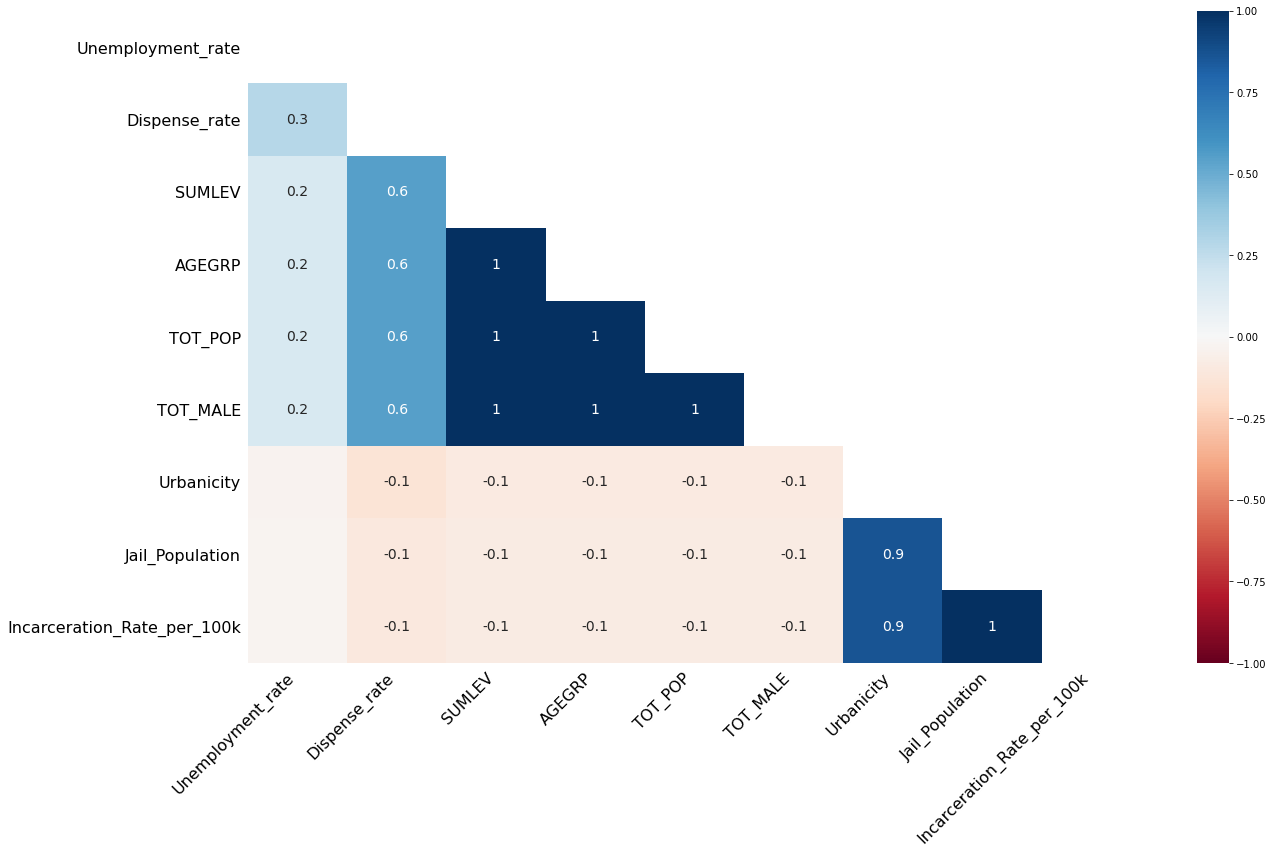

In [12]:
### CORRELATION ACCORDING MISSING VALUES 
msno.heatmap(geogon_nodem);

The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another: 

documentation: https://github.com/ResidentMario/missingno 

In [13]:
# detailed numbers for correlations for matrix above 
df = geogon_nodem.iloc[:, [i for i, n in enumerate(np.var(geogon_nodem.isnull(), axis='rows')) if n > 0]]
corr_mat = df.isnull().corr()
corr_mat

,Unemployment_rate,Dispense_rate,SUMLEV,AGEGRP,TOT_POP,TOT_MALE,Urbanicity,Jail_Population,Incarceration_Rate_per_100k
Unemployment_rate,1.000000,0.283027,0.158532,0.158532,0.158532,0.158532,-0.038610,-0.025133,-0.025133
Dispense_rate,0.283027,1.000000,0.548387,0.548387,0.548387,0.548387,-0.140034,-0.108905,-0.108905
SUMLEV,0.158532,0.548387,1.000000,1.000000,1.000000,1.000000,-0.093264,-0.079084,-0.079084
AGEGRP,0.158532,0.548387,1.000000,1.000000,1.000000,1.000000,-0.093264,-0.079084,-0.079084
TOT_POP,0.158532,0.548387,1.000000,1.000000,1.000000,1.000000,-0.093264,-0.079084,-0.079084
TOT_MALE,0.158532,0.548387,1.000000,1.000000,1.000000,1.000000,-0.093264,-0.079084,-0.079084
Urbanicity,-0.038610,-0.140034,-0.093264,-0.093264,-0.093264,-0.093264,1.000000,0.866623,0.866623
Jail_Population,-0.025133,-0.108905,-0.079084,-0.079084,-0.079084,-0.079084,0.866623,1.000000,1.000000
Incarceration_Rate_per_100k,-0.025133,-0.108905,-0.079084,-0.079084,-0.079084,-0.079084,0.866623,1.000000,1.000000


### Filling in missing incarceration data

In [14]:
geogon_od.groupby('Year').mean()

,Deaths,Population,Cruder_Rate,Deathrate_per_100,Unemployment_rate,Dispense_rate,SUMLEV,AGEGRP,TOT_POP,TOT_MALE,...,NH_FEMALE,H_MALE,H_FEMALE,Jail_Population,Incarceration_Rate_per_100k,PovertyCount,PovertyPercentage,MedianHHI,Latitude,Longitude
Year,,,,,,,,,,,,,,,,,,,,,
1999.0,43.555921,572798.555921,8.030704,0.008031,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1365.668772,367.767509,66356.690789,11.136842,43173.726974,37.915685,-92.371327
2000.0,41.021407,550509.048930,8.089048,0.008089,4.004281,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1303.648084,362.731136,59734.932722,10.470336,45309.226300,37.931566,-91.039656
2001.0,39.828418,502528.361930,9.292622,0.009293,4.743164,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1162.730682,366.685426,56260.646113,11.067024,44232.455764,37.669659,-89.731386
2002.0,42.926606,454856.417431,11.062642,0.011063,5.726376,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1074.480865,379.830673,53662.217890,11.449083,44207.417431,37.834022,-90.865661
2003.0,40.972441,408695.933071,12.437209,0.012437,5.991339,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,990.888971,388.894506,50288.624016,12.100394,44088.791339,37.604391,-90.601783
2004.0,40.095841,384420.708861,13.196182,0.013196,5.647378,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,946.835695,403.350902,48465.262206,12.589873,44764.520796,37.690760,-90.378170
2005.0,41.963979,373678.807890,13.884325,0.013884,5.298100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,929.928615,407.062611,46934.948542,13.316981,46298.166381,37.692520,-90.566926
2006.0,43.388805,347913.352496,15.756374,0.015756,4.874848,92.066415,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,881.250457,421.629811,43936.285930,13.477156,47908.633888,37.783387,-89.958696
2007.0,43.421583,340280.787050,16.184708,0.016185,4.742878,95.457698,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,855.930089,418.580790,41735.007194,13.179137,49954.489209,37.633187,-90.221341


In [16]:
# Get 2019 and 2018 incarceration columns 
incar19 = geogon_od[geogon_od['Year'] == 2019][['FIPS', 'Incarceration_Rate_per_100k']]
incar18 = geogon_od[geogon_od['Year'] == 2018][['FIPS', 'Incarceration_Rate_per_100k']]

# Merge 2018 rates to 2019 counties 
incar19 = incar19.merge(incar18, on = ['FIPS'], how = 'left')
incar19 = incar19.drop('Incarceration_Rate_per_100k_x', axis = 1)

# Place 2019's new rate back into df 
geogon_od.loc[geogon_od['Year'] == 2019, 'Incarceration_Rate_per_100k'] = np.array(incar19['Incarceration_Rate_per_100k_y'])
geogon_od[geogon_od['Year'] == 2019]['Incarceration_Rate_per_100k']

13755    477.31
13756    369.20
13757    673.96
13758    676.19
13759    523.14
          ...  
14732    272.00
14733       NaN
14734       NaN
14735       NaN
14736    516.48
Name: Incarceration_Rate_per_100k, Length: 982, dtype: float64

In [17]:
# Check the proportion of missing variable that are now present in 2019 incarcertation rates 
geogon_od[geogon_od['Year'] == 2018]['Incarceration_Rate_per_100k'].isnull().sum()

33

In [18]:
geogon_od[geogon_od['Year'] == 2019]['Incarceration_Rate_per_100k'].isnull().sum()

143

In [19]:
len(geogon_od[geogon_od['Year'] == 2019]['Incarceration_Rate_per_100k'])

982

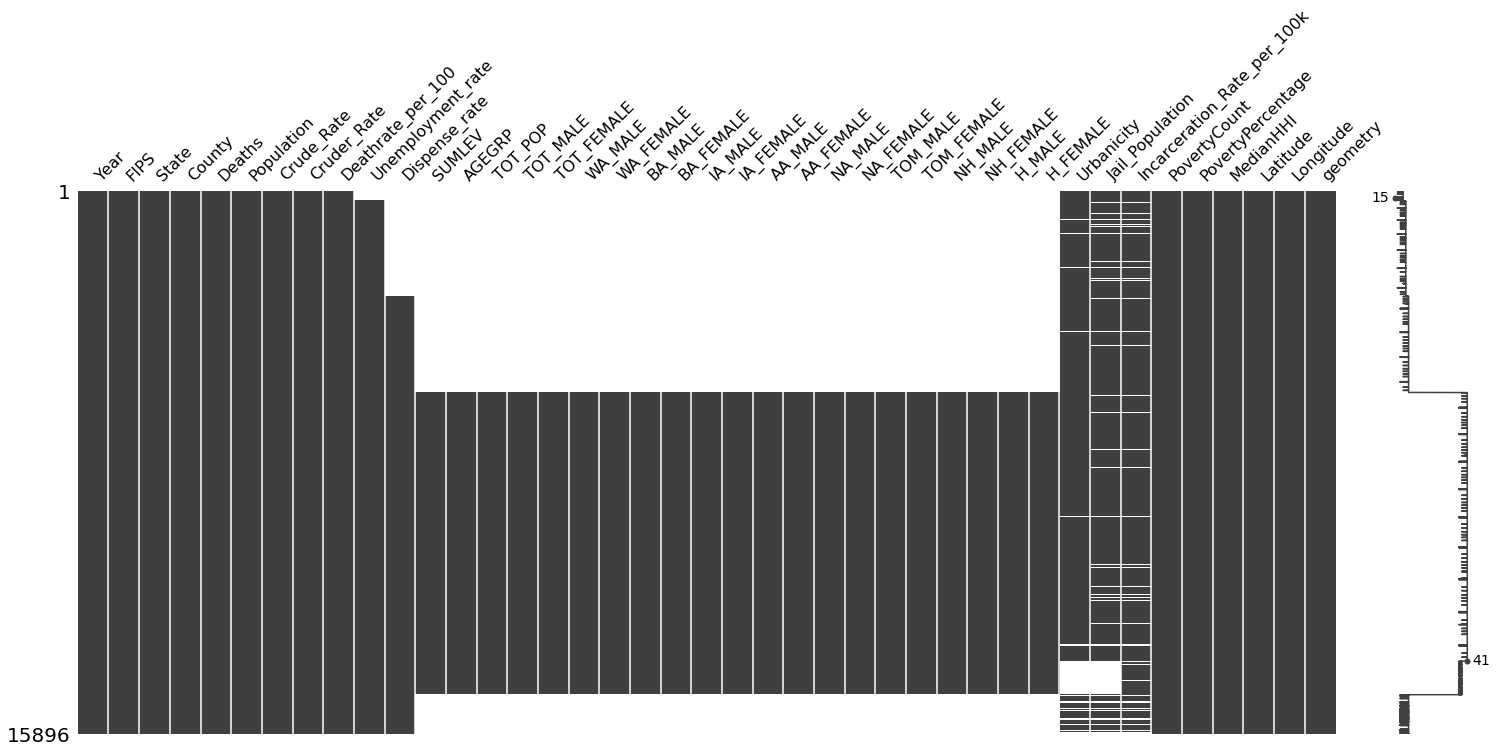

In [21]:
msno.matrix(geogon_od);

### Quantifying the urbanicity column

In [22]:
geogon_od['Urbanicity'].unique()

array(['small/mid', 'urban', 'rural', 'suburban', nan], dtype=object)

In [23]:
urban_dict = {'rural' : 1, 'small/mid' : 2, 'suburban': 3, 'urban' : 4}
geogon_od = geogon_od.replace({"Urbanicity": urban_dict})
geogon_od['Urbanicity']

0        2.0
1        4.0
2        2.0
3        2.0
4        2.0
        ... 
15891    NaN
15892    NaN
15893    NaN
15894    NaN
15895    1.0
Name: Urbanicity, Length: 15896, dtype: float64

## Exhaustive Feature Selection
We first use this variable selection technique before we fit our OLS model so that we can see which predictors we should include.

In [26]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [27]:
# Filter to years 2010 - 2019
geogon_dec = geogon_od[(geogon_od['Year'] >= 2010) & (geogon_od['Year'] <= 2019)]
geogon_dec = geogon_dec.dropna()
geogon_decy = geogon_dec.copy()

# Dropping variables that we don't plan to include as covariates
# Excluding female variables
geogon_dec = geogon_dec.drop(['Deaths', 'Deathrate per 100', 'Crude Rate', 'Cruder Rate',
                              'FIPS', 'State', 'County', 'geometry', 'SUMLEV', 'AGEGRP',
                              'Longitude', 'Latitude', 'TOT_POP', 'TOT_FEMALE', 'WA_FEMALE',
                              'BA_FEMALE', 'IA_FEMALE', 'AA_FEMALE', 'NA_FEMALE', 'NH_FEMALE',
                              'TOM_FEMALE', 'H_FEMALE'], axis = 1)
geogon_dec

,Year,Population,Unemployment_rate,Dispense_rate,TOT_MALE,WA_MALE,BA_MALE,IA_MALE,AA_MALE,NA_MALE,TOM_MALE,NH_MALE,H_MALE,Urbanicity,Jail Population,Incarceration Rate per 100k,PovertyCount,PovertyPercentage,MedianHHI
5902,2010.0,182265.0,9.9,143.8,89620.0,78717.0,8422.0,661.0,551.0,73.0,1196.0,85166.0,4454.0,2.0,734.54,624.90,24056.0,13.3,47618.0
5903,2010.0,57322.0,9.7,60.1,28385.0,27415.0,424.0,178.0,48.0,35.0,285.0,25801.0,2584.0,3.0,124.25,332.87,9358.0,16.5,42906.0
5904,2010.0,118572.0,11.2,182.5,57096.0,44125.0,11327.0,323.0,375.0,63.0,883.0,54969.0,2127.0,2.0,505.38,639.24,27152.0,23.5,37916.0
5905,2010.0,43643.0,10.1,114.7,21603.0,19011.0,2147.0,109.0,64.0,56.0,216.0,19623.0,1980.0,3.0,175.00,611.12,8813.0,20.4,38553.0
5906,2010.0,38319.0,11.6,145.7,19784.0,12173.0,6618.0,644.0,38.0,13.0,298.0,19331.0,453.0,1.0,185.12,730.49,9135.0,26.1,31365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13750,2018.0,103718.0,3.0,45.4,51691.0,49477.0,677.0,275.0,535.0,28.0,699.0,45581.0,6110.0,1.0,297.00,436.26,10114.0,10.1,64234.0
13751,2018.0,135693.0,2.6,48.2,67275.0,64370.0,871.0,255.0,889.0,31.0,859.0,65042.0,2233.0,3.0,229.00,262.63,6059.0,4.5,75799.0
13752,2018.0,403072.0,2.7,51.1,197976.0,183308.0,3632.0,640.0,7362.0,104.0,2930.0,188228.0,9748.0,3.0,532.00,206.18,19937.0,5.0,87333.0
13753,2018.0,171020.0,2.8,44.6,85991.0,78554.0,2644.0,701.0,2454.0,45.0,1593.0,82301.0,3690.0,2.0,310.00,272.00,16915.0,10.4,57785.0


In [28]:
geogon_dec.columns

Index(['Year', 'Population', 'Unemployment_rate', 'Dispense_rate', 'TOT_MALE',
       'WA_MALE', 'BA_MALE', 'IA_MALE', 'AA_MALE', 'NA_MALE', 'TOM_MALE',
       'NH_MALE', 'H_MALE', 'Urbanicity', 'Jail Population',
       'Incarceration Rate per 100k', 'PovertyCount', 'PovertyPercentage',
       'MedianHHI'],
      dtype='object')

In [70]:
import numpy as np
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS


# Run exhaustive search with linear regression

y = np.array(geogon_decy['Cruder Rate'])

X = np.array(standardize(geogon_dec))

lr = LinearRegression()

efs = EFS(lr, 
          min_features=5,
          max_features=19,
          scoring='neg_mean_squared_error',
          cv=5,
          print_progress = True,
          n_jobs = 2)

efs.fit(X, y)

print('Best MSE score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)

Features: 518507/519252


Best subset: (0, 2, 3, 8, 10, 11, 14, 15, 16, 18)


In [79]:
# Print the variables that EFS determined is the best subset
geogon_dec.columns[[0, 2, 3, 8, 10, 11, 14, 15, 16, 18]]

Index(['Year', 'Unemployment_rate', 'Dispense_rate', 'AA_MALE', 'TOM_MALE',
       'NH_MALE', 'Jail Population', 'Incarceration Rate per 100k',
       'PovertyCount', 'MedianHHI'],
      dtype='object')

## Calculating VIF

### Manually chosen variables

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

C:\Users\ashmj\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [14]:
# Determining which variables to include when calculating VIF

# Excluding string variables and ones that have high VIF

noninclude_features = ['Year', 'FIPS', 'State', 'County', 'Latitude',
                       'Longitude', 'geometry', 'Crude Rate', 'TOT_POP', 'AGEGRP', 'Jail Population',
                       'Deathrate per 100', 'SUMLEV', 'TOT_MALE', 'BA_MALE', 'IA_MALE',
                       'AA_MALE', 'NA_MALE', 'TOM_MALE', 'NH_MALE', 'H_MALE', 'TOT_FEMALE',
                       'WA_FEMALE', 'BA_FEMALE', 'IA_FEMALE', 'AA_FEMALE', 'NA_FEMALE', 'TOM_FEMALE',
                       'NH_FEMALE', 'H_FEMALE', 'Population', 'PovertyCount', 'Deaths', 'MedianHHI', 'Cruder Rate']
geogon_num = geogon_od.drop(noninclude_features, axis = 1)
geogon_num = geogon_num.dropna()

In [16]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = geogon_num.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(geogon_num.values, i)
                          for i in range(len(geogon_num.columns))]
  
print(vif_data)

                       feature        VIF
0            Unemployment_rate   8.926970
1                Dispense_rate   8.362615
2                      WA_MALE   1.726278
3                   Urbanicity   4.999564
4  Incarceration Rate per 100k   4.045233
5            PovertyPercentage  11.713832


### Best Subset Variables

In [36]:
geogon_best = geogon_dec[['Year', 'Unemployment_rate', 'Dispense_rate', 'AA_MALE', 'TOM_MALE',
       'NH_MALE', 'Jail Population', 'Incarceration Rate per 100k',
       'PovertyCount', 'MedianHHI']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = geogon_best.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(geogon_best.values, i)
                          for i in range(len(geogon_best.columns))]

vif_data = vif_data.set_index('feature')
vif_data

,VIF
feature,
Year,68.784791
Unemployment_rate,8.954940
Dispense_rate,10.116277
AA_MALE,5.854949
TOM_MALE,14.211463
NH_MALE,14.546340
Jail Population,9.974360
Incarceration Rate per 100k,4.811989
PovertyCount,13.589621


In [40]:
fivenum_best = geogon_best.describe().transpose()
pd.concat([fivenum_best, vif_data], axis = 1)

,count,mean,std,min,25%,50%,75%,max,VIF
Year,7591.0,2014.218285,2.585592,2010.00,2012.000,2014.00,2016.000,2018.00,68.784791
Unemployment_rate,7591.0,6.542590,2.725402,2.00,4.500,6.00,8.000,29.40,8.954940
Dispense_rate,7591.0,90.727335,40.130801,9.90,64.000,83.90,109.300,426.40,10.116277
AA_MALE,7591.0,8407.628903,34112.541448,5.00,296.000,1008.00,4469.000,720458.00,5.854949
TOM_MALE,7591.0,3730.123040,8132.088403,36.00,699.000,1474.00,3502.000,154085.00,14.211463
NH_MALE,7591.0,117908.745752,179201.669693,2956.00,33490.500,61169.00,127541.500,2539478.00,14.546340
Jail Population,7591.0,683.893442,1178.096923,3.00,185.000,347.00,728.500,19091.94,9.974360
Incarceration Rate per 100k,7591.0,423.926483,278.985128,4.25,251.035,358.88,522.285,4265.42,4.811989
PovertyCount,7591.0,42216.501910,91349.717261,1527.00,10491.500,18623.00,40665.500,1873522.00,13.589621
MedianHHI,7591.0,53625.945330,14747.719159,22289.00,43426.000,50612.00,60041.500,140382.00,31.760316


Looking at all the VIF scores, there is high multicollinearity within the chosen subset (VIF > 4). The `XX_MALE` columns are likely correlated with each other, since they are all a proportion of the greater population. It seems like `Year` has the highest multicollinearity with other variables because each variable's pattern changes significantly depending on the year. `Jail Population` and `Incarceration Rate per 100k` would also be correlated since they are both variables describing the jail population. `Poverty Count`, `MedianHHI`, and `Unemployment_rate` would also be correlated since they are indicators of county wealth. Some options to decrease the multicollinearity would be to drop certain columns or conduct PCA/LASSO/Ridge Regression.

## OLS Modeling

In [25]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [46]:
## STANDARDIZE OUR NON NUMERIC VARIABLES ## 
nonnum_features = ['Year', 'FIPS', 'State', 'County', 'Latitude',
                   'Longitude', 'geometry']
stzd_geogon = standardize(geogon_od.drop(nonnum_features, axis = 1))
stzd_geogon[nonnum_features] = geogon_od[nonnum_features]
stzd_geogon


# Convert to geopandas 
# stzd_geogon = gpd.GeoDataFrame(stzd_geogon)

# Convert FIPS to string 
stzd_geogon['FIPS'] = stzd_geogon['FIPS'].astype(str).str.zfill(5)
stzd_geogon.dtypes

/Users/meera/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/meera/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


AA_FEMALE                      float64
AA_MALE                        float64
AGEGRP                         float64
BA_FEMALE                      float64
BA_MALE                        float64
Crude_Rate                      object
Cruder_Rate                    float64
Deathrate_per_100              float64
Deaths                         float64
Dispense_rate                  float64
H_FEMALE                       float64
H_MALE                         float64
IA_FEMALE                      float64
IA_MALE                        float64
Incarceration_Rate_per_100k    float64
Jail_Population                float64
MedianHHI                      float64
NA_FEMALE                      float64
NA_MALE                        float64
NH_FEMALE                      float64
NH_MALE                        float64
Population                     float64
PovertyCount                   float64
PovertyPercentage              float64
SUMLEV                         float64
TOM_FEMALE               

In [27]:
### FILTER TO WRITE-UP YEARS ### 
stzd_geogon15 = stzd_geogon[(stzd_geogon['Year'] >= 2010) & (stzd_geogon['Year'] <= 2019)] 

# rename cols to have no spaces 
stzd_geogon15 = stzd_geogon15[['Year', 'AA_FEMALE', 'AA_MALE', 'BA_FEMALE', 'BA_MALE', 'Urbanicity', 'Cruder_Rate', 'Dispense_rate', 
                               'H_FEMALE', 'H_MALE', 'IA_FEMALE', 'IA_MALE', 'Incarceration_Rate_per_100k', 'MedianHHI',
                               'NA_FEMALE', 'NA_MALE', 'NH_FEMALE', 'NH_MALE', 'PovertyPercentage', 'TOM_FEMALE', 
                               'TOM_MALE', 'TOT_FEMALE', 'TOT_MALE', 'Unemployment_rate', 'WA_FEMALE', 'WA_MALE',
                               'Jail_Population', 'PovertyCount']]
stzd_geogon15

,Year,AA_FEMALE,AA_MALE,BA_FEMALE,BA_MALE,Urbanicity,Cruder_Rate,Dispense_rate,H_FEMALE,H_MALE,...,PovertyPercentage,TOM_FEMALE,TOM_MALE,TOT_FEMALE,TOT_MALE,Unemployment_rate,WA_FEMALE,WA_MALE,Jail_Population,PovertyCount
5902,2010.0,-0.231379,-0.238974,-0.235517,-0.240625,-0.304556,-0.409017,1.396442,-0.222770,-0.220213,...,-0.098955,-0.310467,-0.311222,-0.212214,-0.213458,1.449969,-0.170838,-0.174712,-0.039441,-0.210906
5903,2010.0,-0.250251,-0.253012,-0.387928,-0.407600,0.856906,-0.182721,-0.577984,-0.236235,-0.236765,...,0.505728,-0.412779,-0.412393,-0.436746,-0.434394,1.372003,-0.437599,-0.431517,-0.488617,-0.370065
5904,2010.0,-0.239150,-0.243886,-0.159893,-0.179977,-0.304556,-0.163833,2.309349,-0.238921,-0.240810,...,1.828472,-0.345331,-0.345982,-0.324234,-0.330805,1.956744,-0.346355,-0.347871,-0.208104,-0.177380
5905,2010.0,-0.250201,-0.252565,-0.355643,-0.371629,0.856906,0.369377,0.709993,-0.241827,-0.242111,...,1.242686,-0.425703,-0.420056,-0.460908,-0.458864,1.527934,-0.480043,-0.473585,-0.451265,-0.375966
5906,2010.0,-0.250806,-0.253291,-0.294024,-0.278287,-1.466018,0.432862,1.441262,-0.252166,-0.255627,...,2.319777,-0.420381,-0.410949,-0.473053,-0.465427,2.112675,-0.517263,-0.507815,-0.443816,-0.372479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14732,2019.0,-0.183113,-0.184189,-0.367967,-0.358100,NaN,-0.596206,-0.931824,-0.222127,-0.225966,...,-0.779223,-0.284400,-0.263024,-0.240108,-0.224975,-1.239840,-0.184171,-0.174667,NaN,-0.298520
14733,2019.0,-0.233271,-0.235039,-0.389216,-0.408456,NaN,-0.254354,-0.799723,-0.244645,-0.249068,...,-0.590260,-0.394641,-0.389849,-0.408699,-0.407096,-0.966961,-0.402340,-0.398449,NaN,-0.387650
14734,2019.0,-0.249343,-0.252007,-0.393204,-0.413362,NaN,0.569543,-0.863414,-0.243360,-0.246590,...,-0.174540,-0.383562,-0.377522,-0.469676,-0.465622,-0.655099,-0.505498,-0.495510,NaN,-0.417938
14735,2019.0,-0.234608,-0.236239,-0.377178,-0.384761,NaN,-0.279840,-0.733673,-0.191039,-0.192128,...,-0.817016,-0.292220,-0.275795,-0.366790,-0.354917,-1.044926,-0.351729,-0.338030,NaN,-0.371840


In [28]:
print("sm.OLS will drop", len(stzd_geogon15) - len(stzd_geogon15.dropna()), "observations")
stzd_geogon15.dropna()

sm.OLS will drop 1244 observations


,Year,AA_FEMALE,AA_MALE,BA_FEMALE,BA_MALE,Urbanicity,Cruder_Rate,Dispense_rate,H_FEMALE,H_MALE,...,PovertyPercentage,TOM_FEMALE,TOM_MALE,TOT_FEMALE,TOT_MALE,Unemployment_rate,WA_FEMALE,WA_MALE,Jail_Population,PovertyCount
5902,2010.0,-0.231379,-0.238974,-0.235517,-0.240625,-0.304556,-0.409017,1.396442,-0.222770,-0.220213,...,-0.098955,-0.310467,-0.311222,-0.212214,-0.213458,1.449969,-0.170838,-0.174712,-0.039441,-0.210906
5903,2010.0,-0.250251,-0.253012,-0.387928,-0.407600,0.856906,-0.182721,-0.577984,-0.236235,-0.236765,...,0.505728,-0.412779,-0.412393,-0.436746,-0.434394,1.372003,-0.437599,-0.431517,-0.488617,-0.370065
5904,2010.0,-0.239150,-0.243886,-0.159893,-0.179977,-0.304556,-0.163833,2.309349,-0.238921,-0.240810,...,1.828472,-0.345331,-0.345982,-0.324234,-0.330805,1.956744,-0.346355,-0.347871,-0.208104,-0.177380
5905,2010.0,-0.250201,-0.252565,-0.355643,-0.371629,0.856906,0.369377,0.709993,-0.241827,-0.242111,...,1.242686,-0.425703,-0.420056,-0.460908,-0.458864,1.527934,-0.480043,-0.473585,-0.451265,-0.375966
5906,2010.0,-0.250806,-0.253291,-0.294024,-0.278287,-1.466018,0.432862,1.441262,-0.252166,-0.255627,...,2.319777,-0.420381,-0.410949,-0.473053,-0.465427,2.112675,-0.517263,-0.507815,-0.443816,-0.372479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13750,2018.0,-0.237485,-0.239420,-0.384637,-0.402318,-1.466018,0.016646,-0.924747,-0.206874,-0.205555,...,-0.703638,-0.373353,-0.366416,-0.357141,-0.350306,-1.239840,-0.329619,-0.321080,-0.361472,-0.361878
13751,2018.0,-0.226711,-0.229541,-0.378734,-0.398268,0.856906,-0.322838,-0.858697,-0.236262,-0.239872,...,-1.761834,-0.357930,-0.348647,-0.300361,-0.294079,-1.395771,-0.253419,-0.246530,-0.411521,-0.405788
13752,2018.0,-0.053859,-0.048887,-0.337059,-0.340626,0.856906,-0.153014,-0.790288,-0.170256,-0.173354,...,-1.667352,-0.126154,-0.118653,0.174371,0.177490,-1.356788,0.364868,0.348843,-0.188511,-0.255509
13753,2018.0,-0.184678,-0.185863,-0.370882,-0.361253,-0.304556,-0.259066,-0.943618,-0.223192,-0.226976,...,-0.646949,-0.288093,-0.267133,-0.242169,-0.226552,-1.317806,-0.185704,-0.175528,-0.351904,-0.288233


In [29]:
"Cruder_Rate ~ AA_FEMALE + AA_MALE + BA_FEMALE + BA_MALE + \
H_FEMALE + H_MALE + IA_FEMALE + IA_MALE + NA_FEMALE + NA_MALE + NH_FEMALE + NH_MALE + \
TOM_FEMALE + TOM_MALE + WA_FEMALE + WA_MALE + \
Unemployment_rate + Dispense_rate + Incarceration_Rate_per_100k + PovertyPercentage + MedianHHI"

'Cruder_Rate ~ AA_FEMALE + AA_MALE + BA_FEMALE + BA_MALE + H_FEMALE + H_MALE + IA_FEMALE + IA_MALE + NA_FEMALE + NA_MALE + NH_FEMALE + NH_MALE + TOM_FEMALE + TOM_MALE + WA_FEMALE + WA_MALE + Unemployment_rate + Dispense_rate + Incarceration_Rate_per_100k + PovertyPercentage + MedianHHI'

### Modeling without spatial covariates 

In [34]:
### MANUALLY CHOSEN FEATURES ### 
y, X = dmatrices("Cruder_Rate ~ Year + WA_MALE + Urbanicity + Unemployment_rate + \
Dispense_rate + Incarceration_Rate_per_100k + PovertyPercentage + MedianHHI", 
                 data=stzd_geogon15, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            Cruder_Rate   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     299.8
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:44:52   Log-Likelihood:                -9572.3
No. Observations:                7591   AIC:                         1.916e+04
Df Residuals:                    7582   BIC:                         1.923e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [33]:
### OLS WITH EXHAUSTIVE BEST SUBSET 
y, X = dmatrices("Cruder_Rate ~ Year + Unemployment_rate + Dispense_rate + \
                 AA_MALE + TOM_MALE + NH_MALE + Jail_Population + \
                 Incarceration_Rate_per_100k + PovertyCount + MedianHHI", 
                 data=stzd_geogon15, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

bss_coef = round(res.params, 3)
bss_pval = round(res.pvalues, 3)
bss_df = pd.concat([bss_coef, bss_pval], axis = 1)
bss_df = bss_df.rename(columns={0: 'Estimate', 1: 'P-value'})
bss_df.loc['spatmax'] = ['N/A', 'N/A']
bss_df.loc['spatmean'] = ['N/A', 'N/A']
bss_df

                            OLS Regression Results                            
Dep. Variable:            Cruder_Rate   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     249.0
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:44:35   Log-Likelihood:                -9537.4
No. Observations:                7591   AIC:                         1.910e+04
Df Residuals:                    7580   BIC:                         1.917e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

,Estimate,P-value
Intercept,-367.99,0.0
Year,0.183,0.0
Unemployment_rate,0.152,0.0
Dispense_rate,0.299,0.0
AA_MALE,0.098,0.0
TOM_MALE,-0.146,0.0
NH_MALE,0.222,0.0
Jail_Population,-0.1,0.001
Incarceration_Rate_per_100k,0.023,0.044
PovertyCount,-0.143,0.0


Note that we did not include spatial components in our exhaustive search. 

There is a low R-squared but it's slightly better than manually chosen

F-test is 0 so we reject the null hypothesis that the model with no covariates is better – i.e. this says our model is better nothing! This applies for all of our models. 

All our variables are significant. This may be due to our large number of observations (7591 observations vs 10 features). 

We compare the AIC of our different models. This exhaustive search (with no spat comp) has the lowest AIC (an indication of a better model). 

### Modeling with naive spatial components

We hypothesize that there are spatial autocorrelations and spillover effects between counties. So we will include spatmax (maximum drug overdose death rate of adjacent counties) and spatmean (average drug overdose death rate of adjacent counties) as variables of interest in our model.

In [36]:
#### CREATING NAIVE SPATCOMP TABLE ### 
geogon_spat = geogon_od[(geogon_od['Year'] >= 2010) & (geogon_od['Year'] <= 2019)]
geogon_spat = geogon_spat.drop(['Latitude', 'Longitude', 'geometry', 'AGEGRP', 'SUMLEV'], axis=1)

# Quantify Urbanicity 
urban_dict = {'rural' : 1, 'small/mid' : 2, 'suburban': 3, 'urban' : 4}
geogon_spat = geogon_spat.replace({"Urbanicity": urban_dict})

geogon_spat

,Year,FIPS,State,County,Deaths,Population,Crude_Rate,Cruder_Rate,Deathrate_per_100,Unemployment_rate,...,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE,Urbanicity,Jail_Population,Incarceration_Rate_per_100k,PovertyCount,PovertyPercentage,MedianHHI
5902,2010.0,01003,Alabama,"Baldwin County, AL",26.0,182265.0,14.26,14.264944,0.014265,9.9,...,85166.0,89879.0,4454.0,3613.0,2.0,734.54,624.90,24056.0,13.3,47618.0
5903,2010.0,01009,Alabama,"Blount County, AL",10.0,57322.0,Unreliable,17.445309,0.017445,9.7,...,25801.0,26907.0,2584.0,2084.0,3.0,124.25,332.87,9358.0,16.5,42906.0
5904,2010.0,01015,Alabama,"Calhoun County, AL",21.0,118572.0,17.71,17.710758,0.017711,11.2,...,54969.0,59533.0,2127.0,1779.0,2.0,505.38,639.24,27152.0,23.5,37916.0
5905,2010.0,01021,Alabama,"Chilton County, AL",11.0,43643.0,Unreliable,25.204500,0.025205,10.1,...,19623.0,20601.0,1980.0,1449.0,3.0,175.00,611.12,8813.0,20.4,38553.0
5906,2010.0,01053,Alabama,"Escambia County, AL",10.0,38319.0,Unreliable,26.096714,0.026097,11.6,...,19331.0,18286.0,453.0,275.0,1.0,185.12,730.49,9135.0,26.1,31365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14732,2019.0,55139,Wisconsin,"Winnebago County, WI",20.0,171907.0,11.63,11.634198,0.011634,3.0,...,82624.0,81793.0,3804.0,3686.0,NaN,NaN,272.00,15965.0,9.7,59643.0
14733,2019.0,55141,Wisconsin,"Wood County, WI",12.0,72999.0,Unreliable,16.438581,0.016439,3.7,...,34757.0,35919.0,1194.0,1129.0,NaN,NaN,NaN,7734.0,10.7,57325.0
14734,2019.0,56013,Wyoming,"Fremont County, WY",11.0,39261.0,Unreliable,28.017626,0.028018,4.5,...,18256.0,18256.0,1474.0,1275.0,NaN,NaN,NaN,4937.0,12.9,57953.0
14735,2019.0,56021,Wyoming,"Laramie County, WY",16.0,99500.0,Unreliable,16.080402,0.016080,3.5,...,42786.0,41871.0,7627.0,7216.0,NaN,NaN,NaN,9194.0,9.5,69613.0


In [37]:
spatcomp = pd.read_csv('spatialcomp.csv').reset_index(drop = True)
spatcomp = spatcomp.drop('Unnamed: 0', axis = 1)
spatcomp.columns = ['Year', 'FIPS', 'spatmax', 'spatmean']
spatcomp['FIPS'] =  spatcomp['FIPS'].astype(str).str.zfill(5)
spatcomp

,Year,FIPS,spatmax,spatmean
0,2010,01001,25.204500,16.526161
1,2010,01003,26.096714,16.138937
2,2010,01005,NaN,NaN
3,2010,01007,25.204500,15.378684
4,2010,01009,50.728854,22.318995
...,...,...,...,...
35459,2020,72149,NaN,NaN
35460,2020,72151,NaN,NaN
35461,2020,72153,NaN,NaN
35462,2020,78020,NaN,NaN


In [38]:
# MERGE 
geogon_spatcomp = geogon_spat.merge(spatcomp, on = ['Year', 'FIPS'], how = 'left')

# STANDARDIZE 
nostzd_features = ['Year', 'FIPS', 'State', 'County', 'Crude_Rate', 'Cruder_Rate'] 
stzd_geospat = standardize(geogon_spatcomp.drop(nostzd_features, axis = 1))

stzd_geospat[nostzd_features] = geogon_spatcomp[nostzd_features]


# # DROP NA ROWS 
print("sm.OLS will drop", len(stzd_geospat) - len(stzd_geospat.dropna()), "observations")
stzd_geospat.dropna()

sm.OLS will drop 1769 observations


,Deaths,Population,Deathrate_per_100,Unemployment_rate,Dispense_rate,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,...,PovertyPercentage,MedianHHI,spatmax,spatmean,Year,FIPS,State,County,Crude_Rate,Cruder_Rate
0,-0.317829,-0.214403,-0.583092,1.340094,1.427865,-0.212854,-0.213458,-0.212214,-0.174712,-0.170838,...,-0.260658,-0.479678,-0.225981,-0.549059,2010.0,01003,Alabama,"Baldwin County, AL",14.26,14.264944
1,-0.497956,-0.435446,-0.354042,1.266964,-0.624997,-0.435650,-0.434394,-0.436746,-0.431517,-0.437599,...,0.336784,-0.787107,1.159894,-0.017769,2010.0,01009,Alabama,"Blount County, AL",Unreliable,17.445309
2,-0.374119,-0.327086,-0.334924,1.815445,2.377038,-0.327505,-0.330805,-0.324234,-0.347871,-0.346355,...,1.643689,-1.112673,-0.684671,-0.671256,2010.0,01015,Alabama,"Calhoun County, AL",17.71,17.710758
3,-0.486698,-0.459646,0.204776,1.413225,0.714146,-0.459966,-0.458864,-0.460908,-0.473585,-0.480043,...,1.064917,-1.071113,-0.944412,-0.790751,2010.0,01021,Alabama,"Chilton County, AL",Unreliable,25.204500
4,-0.497956,-0.469065,0.269033,1.961707,1.474466,-0.469371,-0.465427,-0.473053,-0.507815,-0.517263,...,2.129111,-1.540085,-0.839379,-0.832000,2010.0,01053,Alabama,"Escambia County, AL",Unreliable,26.096714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7847,-0.441666,-0.332598,-0.674772,-1.365746,-1.022325,-0.333131,-0.327395,-0.338576,-0.309652,-0.320166,...,-1.343523,0.452526,-0.769278,-0.577038,2018.0,55117,Wisconsin,"Sheboygan County, WI",Unreliable,12.991962
7848,-0.374119,-0.353365,-0.152249,-1.182919,-0.985535,-0.353832,-0.350306,-0.357141,-0.321080,-0.329619,...,-0.858101,0.604413,-0.107726,-0.203059,2018.0,55127,Wisconsin,"Walworth County, WI",20.25,20.247209
7849,-0.374119,-0.296796,-0.495863,-1.329181,-0.916861,-0.297317,-0.294079,-0.300361,-0.246530,-0.253419,...,-1.903625,1.358958,0.418120,-0.043379,2018.0,55131,Wisconsin,"Washington County, WI",15.48,15.476112
7850,0.200036,0.176238,-0.323973,-1.292615,-0.845734,0.175926,0.177490,0.174371,0.348843,0.364868,...,-1.810274,2.111480,0.418120,-0.086436,2018.0,55133,Wisconsin,"Waukesha County, WI",17.86,17.862814


In [39]:
# OLS WITH EXHAUSTIVE BEST SUBSET + spatmax
y, X = dmatrices("Cruder_Rate ~ Year + Unemployment_rate + Dispense_rate + \
                 AA_MALE + TOM_MALE + NH_MALE + Jail_Population + \
                 Incarceration_Rate_per_100k + PovertyCount + MedianHHI + spatmax", 
                 data=stzd_geospat, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())


spatmax_coef = round(res.params, 3)
spatmax_pval = round(res.pvalues, 3)
spatmax_df = pd.concat([spatmax_coef, spatmax_pval], axis = 1)
spatmax_df = spatmax_df.rename(columns={0: 'Estimate', 1: 'P-value'})
spatmax_df.loc['spatmean'] = ['N/A', 'N/A']
spatmax_df

                            OLS Regression Results                            
Dep. Variable:            Cruder_Rate   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     616.4
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:49:46   Log-Likelihood:                -26279.
No. Observations:                7066   AIC:                         5.258e+04
Df Residuals:                    7054   BIC:                         5.266e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

,Estimate,P-value
Intercept,-2593.707,0.0
Year,1.299,0.0
Unemployment_rate,0.958,0.0
Dispense_rate,2.066,0.0
AA_MALE,0.911,0.001
TOM_MALE,-1.12,0.011
NH_MALE,2.034,0.0
Jail_Population,-0.708,0.025
Incarceration_Rate_per_100k,0.712,0.0
PovertyCount,-1.503,0.0


R-squared higher than prev models. ~ doubled! 

F-test is 0 so we reject the null hypothesis that the model with no covariates is better – i.e. this says our model is better nothing! This applies for all of our models. 

All our variables are significant. This may be due to our large number of observations (8835 observations vs 11 features). 

We compare the AIC of our different models. This model has the highest AIC out of all the models.

In [41]:
# OLS WITH EXHAUSTIVE BEST SUBSET + spatmean
y, X = dmatrices("Cruder_Rate ~ Year + Unemployment_rate + Dispense_rate + \
                 AA_MALE + TOM_MALE + NH_MALE + Jail_Population + \
                 Incarceration_Rate_per_100k + PovertyCount + MedianHHI + spatmean", 
                 data=stzd_geospat, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())


spatmean_coef = round(res.params, 3)
spatmean_pval = round(res.pvalues, 3)
spatmean_df = pd.concat([spatmean_coef, spatmean_pval], axis = 1)
spatmean_df = spatmean_df.rename(columns={0: 'Estimate', 1: 'P-value'})
spatmean_df.loc['spatmax'] = ['N/A', 'N/A']
spatmean_df = spatmean_df.reindex(['Intercept', 'Year', 'Unemployment_rate', 'Dispense_rate', 'AA_MALE',
       'TOM_MALE', 'NH_MALE', 'Jail_Population', 'Incarceration_Rate_per_100k',
       'PovertyCount', 'MedianHHI','spatmax', 'spatmean'])

                            OLS Regression Results                            
Dep. Variable:            Cruder_Rate   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     715.3
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:50:10   Log-Likelihood:                -26011.
No. Observations:                7066   AIC:                         5.205e+04
Df Residuals:                    7054   BIC:                         5.213e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

R-squared increase from spatmax to spatmean  

F-test is 0 so we reject the null hypothesis that the model with no covariates is better – i.e. this says our model is better nothing! This applies for all of our models. 

All our variables are significant, except AA_MALE and TOM_MALE. This may be because spatmean is able to explain more variation in our model. Most of our variables are significant - this may be due to our large number of observations (8835 observations vs 11 features). 

We compare the AIC of our different models. This model has a relatively high AIC.

In [42]:
# OLS WITH EXHAUSTIVE BEST SUBSET + SPATCOMP
y, X = dmatrices("Cruder_Rate ~ Year + Unemployment_rate + Dispense_rate + \
                 AA_MALE + TOM_MALE + NH_MALE + Jail_Population + \
                 Incarceration_Rate_per_100k + PovertyCount + MedianHHI + spatmax + spatmean", 
                 data=stzd_geospat, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())


spatcomp_coef = round(res.params, 3)
spatcomp_pval = round(res.pvalues, 3)
spatcomp_df = pd.concat([spatcomp_coef, spatcomp_pval], axis = 1)
spatcomp_df = spatcomp_df.rename(columns={0: 'Estimate', 1: 'P-value'})
spatcomp_df

                            OLS Regression Results                            
Dep. Variable:            Cruder_Rate   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     655.8
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:50:29   Log-Likelihood:                -26011.
No. Observations:                7066   AIC:                         5.205e+04
Df Residuals:                    7053   BIC:                         5.214e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

,Estimate,P-value
Intercept,-2083.644,0.000
Year,1.045,0.000
Unemployment_rate,1.148,0.000
Dispense_rate,1.566,0.000
AA_MALE,0.403,0.142
TOM_MALE,-0.547,0.196
NH_MALE,1.938,0.000
Jail_Population,-0.559,0.066
Incarceration_Rate_per_100k,0.731,0.000
PovertyCount,-1.359,0.000


R-squared did not increase when we include both spatmax and spatmean.

All our variables are significant, except AA_MALE, TOM_MALE, and spatmax. Therefore, spatmax is not significant when we include spatmean. (spatmean > spatmax). This may be because spatmean is able to explain more variation in our model. Most of our variables are significant - this may be due to our large number of observations (8835 observations vs 11 features).


F-test is 0 so we reject the null hypothesis that the model with no covariates is better – i.e. this says our model is better nothing! This applies for all of our models. 
 

We compare the AIC of our different models. This model has a relatively high AIC (also same AIC as the model with just spatmean).

NOTE:

The features discussed above may not the best measure of our model's performance. 
In future analysis, we will be plotting our residuals to determine whether or not it is appropriate to use an OLS fit on our data. Additionally, we will also be using cross validation to measure the accuracy of our model. 

In [43]:
# bss_df.columns = pd.MultiIndex.from_product([['bss_df'], bss_df.columns])
# bss_df
# spatmax_coef = pd.MultiIndex.from_product([['BSS OLS w/ Adjacent County Max'], B.columns])
# spatmean.columns = pd.MultiIndex.from_product([['BSS OLS w/ Adjacent County Max'], B.columns])
# pd.concat([A, B], axis = 1)
ols_outputs = pd.concat([bss_df, spatmax_df, spatmean_df, spatcomp_df],
          axis = 1, keys=(['Best Subset (BSS) OLS',
                           'BSS OLS w/ spatmax',
                           'BSS OLS w/ spatmean',
                           'BSS OLS w/ spatmax & spatmean']))

# from tabulate import tabulate
# print(tabulate(ols_outputs))
ols_outputs.shape

(13, 8)

In [44]:
from IPython.display import display, HTML
display(HTML(ols_outputs.to_html()))

## Attempt at PCA and Elastic Net
We are attempting PCA and Elastic Net to reduce multicollinearity.

The cells below are a duplicate of `PCA_and_EN.ipynb` found in `Analysis\Modeling\PCA_and_EN.ipynb`.

The file `pca_data.csv` can be found in `Data\od_deaths_Versions\pca_data.csv`.

In [53]:
# read in data
df = pd.read_csv('pca_data.csv')
df = df[(df['Year'] >= 2011) & (df['Year'] <= 2019)]
X = df.drop(['Cruder_Rate', 'Crude_Rate', 'geometry', 'FIPS', 'State', 'County', 'Latitude', 'Longitude', 'Urbanicity', 'Jail_Population', 'Incarceration_Rate_per_100k', 'Dispense_rate'], axis = 1)
y = df['Cruder_Rate']
df.isnull().sum()

Year                              0
FIPS                              0
State                             0
County                            0
Deaths                            0
Population                        0
Crude_Rate                        0
Cruder_Rate                       0
Deathrate_per_100                 0
Unemployment_rate                 0
Dispense_rate                     2
SUMLEV                            0
AGEGRP                            0
TOT_POP                           0
TOT_MALE                          0
TOT_FEMALE                        0
WA_MALE                           0
WA_FEMALE                         0
BA_MALE                           0
BA_FEMALE                         0
IA_MALE                           0
IA_FEMALE                         0
AA_MALE                           0
AA_FEMALE                         0
NA_MALE                           0
NA_FEMALE                         0
TOM_MALE                          0
TOM_FEMALE                  

<AxesSubplot:>

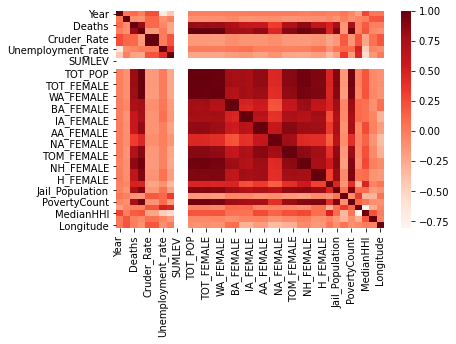

In [54]:
sns.heatmap(df.corr(), cmap = "Reds")

In [55]:
X.isnull().sum()

Year                 0
Deaths               0
Population           0
Deathrate_per_100    0
Unemployment_rate    0
SUMLEV               0
AGEGRP               0
TOT_POP              0
TOT_MALE             0
TOT_FEMALE           0
WA_MALE              0
WA_FEMALE            0
BA_MALE              0
BA_FEMALE            0
IA_MALE              0
IA_FEMALE            0
AA_MALE              0
AA_FEMALE            0
NA_MALE              0
NA_FEMALE            0
TOM_MALE             0
TOM_FEMALE           0
NH_MALE              0
NH_FEMALE            0
H_MALE               0
H_FEMALE             0
PovertyCount         0
PovertyPercentage    0
MedianHHI            0
dtype: int64

### PCA

[1.71064685e+01 2.62349251e+00 2.06388441e+00 1.39683547e+00
 1.14428895e+00 7.56530588e-01 5.85538872e-01 3.91147544e-01
 3.35643288e-01 2.64281927e-01 1.49285091e-01 1.10351246e-01
 4.20483520e-02 2.89688629e-02 1.73611750e-03 1.01156418e-03
 6.03599092e-04 4.71514875e-04 4.02974272e-04 1.90779814e-04
 1.54294547e-04 1.51238411e-05 4.69761717e-31 1.72657277e-31
 9.84680740e-32 9.84680740e-32 9.84680740e-32 9.84680740e-32
 6.29389667e-32]
[6.33494270e+01 9.71543293e+00 7.64306758e+00 5.17282260e+00
 4.23758119e+00 2.80161737e+00 2.16839332e+00 1.44851480e+00
 1.24296900e+00 9.78700465e-01 5.52839121e-01 4.08657591e-01
 1.55715308e-01 1.07278768e-01 6.42926676e-03 3.74606899e-03
 2.23527472e-03 1.74613464e-03 1.49231206e-03 7.06504203e-04
 5.71390357e-04 5.60072740e-05 1.73964227e-30 6.39392029e-31
 3.64651306e-31 3.64651306e-31 3.64651306e-31 3.64651306e-31
 2.33078352e-31]


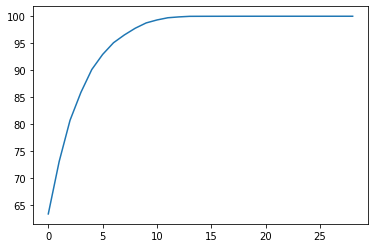

In [56]:
# let's do the PCA
sc = StandardScaler()
x_scaled = sc.fit_transform(X)
pca = PCA(n_components = None)
pca.fit(x_scaled)

# these are the eigenvalues
print(pca.explained_variance_)

# these are the explained variances
print(pca.explained_variance_ratio_ * 100)

# make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))

In [57]:
# let's look at feature importance
print(abs( pca.components_ ))

[[3.31294922e-03 1.94047374e-01 2.39517821e-01 4.12148893e-02
  1.72083262e-03 3.25260652e-19 0.00000000e+00 2.39503352e-01
  2.39592743e-01 2.39354415e-01 2.34378457e-01 2.33776833e-01
  1.85597058e-01 1.80309670e-01 1.96001703e-01 1.90352614e-01
  2.10804394e-01 2.11539575e-01 1.30295442e-01 1.32661389e-01
  2.22479573e-01 2.24542855e-01 2.30894375e-01 2.29940226e-01
  2.18381594e-01 2.17084932e-01 2.30126352e-01 7.67146259e-03
  4.81193304e-02]
 [3.47545411e-01 1.33871299e-03 1.50657351e-02 7.96564274e-02
  4.74763927e-01 2.77555756e-17 6.93889390e-18 1.51327891e-02
  1.32117206e-02 1.69826470e-02 8.61491763e-03 1.01339352e-02
  1.11662275e-01 1.15662721e-01 7.85854169e-02 8.18150039e-02
  7.34576248e-02 7.37788593e-02 1.52274871e-01 1.51555164e-01
  8.83877522e-02 8.06398300e-02 2.11885155e-02 1.47089575e-02
  6.62269645e-02 6.76968185e-02 1.18965930e-01 5.08053990e-01
  5.04416366e-01]
 [1.83312346e-01 1.80316644e-01 7.31616583e-02 4.96191506e-02
  1.93428317e-01 0.00000000e+00 0.

<AxesSubplot:>

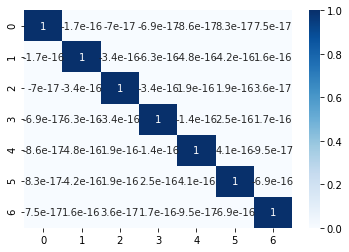

In [58]:
pca = PCA(n_components = 7)
X_pca = pca.fit_transform(x_scaled)
X_pca = pd.DataFrame(X_pca)

sns.heatmap(X_pca.corr(), annot = True, cmap = "Blues")

Okay, so above we did PCA on our dummy dataset (dropping columns with any missing values for our dataset between 2011 - 2019). It seems that it worked, considering after doing PCA and selecting the first 7 principal components, we have low multicollinearity between our variables.

### Transform the Response variables 

<AxesSubplot:>

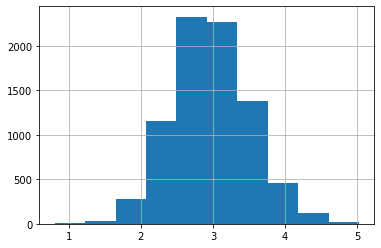

In [59]:
# log transform the response 
# ONLY RUN IT ONCE 

df.head()
df['log_cruder_Rate'] = np.log(df['Cruder_Rate'])
df.head()
df['log_cruder_Rate'].hist()

### Elastic Net
Because PCA lacks interpretablity we are going to introduce Elastic Net in order to decrease variables that have 

Elastic net (that has the ridge penalty) can deal with collinearity better than lasso 

According to Wikepedia ways to deal with multicollinearity include: getting more data, drop a variable, standardize the independent variables, PCA, partial least squares regression, ridge regression.

In [60]:
df = df.drop(['Cruder_Rate', 'Crude_Rate', 'geometry', 'FIPS', 
              'State', 'County', 'Latitude', 'Longitude', 'Urbanicity', 
              'Jail_Population', 'Incarceration_Rate_per_100k', 
              'Deathrate_per_100'], axis = 1)

In [61]:
#Dropping the rows that are empty for the dispense rate 
df = df.dropna(axis = 0)
df.isnull().sum()
print(df.columns)
df

Index(['Year', 'Deaths', 'Population', 'Unemployment_rate', 'Dispense_rate',
       'SUMLEV', 'AGEGRP', 'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE',
       'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE',
       'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE',
       'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE', 'PovertyCount',
       'PovertyPercentage', 'MedianHHI', 'log_cruder_Rate'],
      dtype='object')


,Year,Deaths,Population,Unemployment_rate,Dispense_rate,SUMLEV,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,TOM_MALE,TOM_FEMALE,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE,PovertyCount,PovertyPercentage,MedianHHI,log_cruder_Rate
6680,2011.0,24.0,186717.0,9.0,150.0,50.0,0.0,186558.0,91190.0,95368.0,...,1279.0,1352.0,86720.0,91587.0,4470.0,3781.0,24728.0,13.4,50144.0,2.553630
6681,2011.0,14.0,117797.0,10.3,176.7,50.0,0.0,117744.0,56626.0,61118.0,...,902.0,970.0,54475.0,59282.0,2151.0,1836.0,23974.0,20.9,39060.0,2.475265
6682,2011.0,10.0,80536.0,9.5,180.6,50.0,0.0,80410.0,39736.0,40674.0,...,444.0,455.0,37901.0,39118.0,1835.0,1556.0,14455.0,18.2,39395.0,2.519051
6683,2011.0,11.0,71375.0,11.7,100.6,50.0,0.0,71365.0,35210.0,36155.0,...,742.0,779.0,30026.0,31372.0,5184.0,4783.0,14331.0,20.3,35487.0,2.735118
6684,2011.0,16.0,38095.0,10.7,149.0,50.0,0.0,38204.0,19682.0,18522.0,...,311.0,270.0,19235.0,18245.0,447.0,277.0,8893.0,25.5,32838.0,3.737676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14732,2019.0,20.0,171907.0,3.0,45.1,50.0,0.0,171907.0,86428.0,85479.0,...,1630.0,1506.0,82624.0,81793.0,3804.0,3686.0,15965.0,9.7,59643.0,2.453949
14733,2019.0,12.0,72999.0,3.7,50.7,50.0,0.0,72999.0,35951.0,37048.0,...,488.0,491.0,34757.0,35919.0,1194.0,1129.0,7734.0,10.7,57325.0,2.799631
14734,2019.0,11.0,39261.0,4.5,48.0,50.0,0.0,39261.0,19730.0,19531.0,...,599.0,593.0,18256.0,18256.0,1474.0,1275.0,4937.0,12.9,57953.0,3.332834
14735,2019.0,16.0,99500.0,3.5,53.5,50.0,0.0,99500.0,50413.0,49087.0,...,1515.0,1434.0,42786.0,41871.0,7627.0,7216.0,9194.0,9.5,69613.0,2.777601


#### Cross Validation with Elastic Net

In [101]:
###### from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.linear_model import RidgeCV, LassoCV,ElasticNetCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import model_selection

#Elastic net has different hyperparameters the alpha one and the lambda parameter 
X = df.iloc[:, :-1]
y = df[['log_cruder_Rate']]
X.columns

#Now split your data into training and testing set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state =23)
    
#getting an estimate for alpha and lambda values 

#this searches for multiple alpha values and applied the best oen for you 

enet_cv_model = ElasticNetCV(cv = 10, max_iter=10000).fit(X_train,y_train.values.ravel())
enet_cv_model.alpha_
enet_cv_model.l1_ratio

#just fitting the elastic net model here 
enet_tunes = ElasticNet(alpha = enet_cv_model.alpha_, 
                        max_iter=10000).fit(X_train, y_train)

y_pred = enet_tunes.predict(X_test)
mean_squared_error(y_test,y_pred)

print(enet_tunes.coef_)
print(X.columns)
X.columns[[8, 11, 22, 23, 26, 28]]

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -2.61294744e-07  0.00000000e+00  0.00000000e+00  1.88268191e-08
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -2.43845903e-07  7.91557820e-07
  0.00000000e+00 -0.00000000e+00 -1.46985408e-06 -0.00000000e+00
 -9.49752693e-06]
Index(['Year', 'Deaths', 'Population', 'Unemployment_rate', 'Dispense_rate',
       'SUMLEV', 'AGEGRP', 'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE',
       'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE',
       'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE',
       'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE', 'PovertyCount',
       'PovertyPercentage', 'MedianHHI'],
      dtype='object')


Index(['TOT_MALE', 'WA_FEMALE', 'NH_MALE', 'NH_FEMALE', 'PovertyCount',
       'MedianHHI'],
      dtype='object')

With elastic net the variables that where included are: total males, white females, non-hispanic males, non-hispanic females, poverty count, and median house hold income 